# 2. Hough Transform

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from math import sqrt

In [29]:
# Load image
image_runway = cv2.imread('runway.jpeg', cv2.IMREAD_GRAYSCALE)  # Make sure to use the correct path
image_SpaceXmap = cv2.imread('SpaceXmap.jpg',cv2.IMREAD_GRAYSCALE)  # Make sure to use the correct path

### Canny Edge Detection

In [8]:
def edge_detection(image, threshold1=50, threshold2=100):
    # Smooth the image using a Gaussian filter
    sigma = 1.4
    length = 5
    # Compute Gaussian filter
    k = length // 2  # Half size of the filter
    gaussian = np.zeros([length, length])  # Initialize a zero matrix for the Gaussian filter
    
    # Fill in the Gaussian filter with values based on the equation
    for i in range(length):
        for j in range(length):
            gaussian[i, j] = np.exp(-((i-k) ** 2 + (j-k) ** 2) / (2 * sigma ** 2))
    
    # Normalize the filter to ensure the sum of weights is 1
    gaussian /= 2 * np.pi * sigma ** 2
    gaussian = gaussian / np.sum(gaussian)  # Normalize by the sum of all values in the filter

    # Get image dimensions
    W, H = image.shape
    # Initialize a new image to store the smoothed result
    smoothed = np.zeros([W - k * 2, H - k * 2])

    # Apply the Gaussian filter using a sliding window approach
    for i in range(W - 2 * k):
        for j in range(H - 2 * k):
            smoothed[i, j] = np.sum(image[i:i+length, j:j+length] * gaussian)

    # Convert the result to an unsigned 8-bit integer type
    smoothed = np.uint8(smoothed)
    
    # Sobel filters for calculating gradients in x and y directions
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    W, H = smoothed.shape
    # Initialize matrices to store gradients and direction values
    gradients = np.zeros([W - 2, H - 2])
    direction = np.zeros([W - 2, H - 2])

    # Apply the Sobel operator to calculate the gradient magnitude and direction
    for i in range(W - 2):
        for j in range(H - 2):
            dx = np.sum(smoothed[i:i+3, j:j+3] * Gx)  # Calculate gradient in x-direction
            dy = np.sum(smoothed[i:i+3, j:j+3] * Gy)  # Calculate gradient in y-direction
            gradients[i, j] = np.sqrt(dx ** 2 + dy ** 2)  # Compute gradient magnitude
            # Compute gradient direction
            if dx == 0:
                direction[i, j] = np.pi / 2
            else:
                direction[i, j] = np.arctan(dy / dx)

    # Convert gradient magnitudes to uint8 type
    gradients = np.uint8(gradients)
    W, H = gradients.shape
    nms = np.copy(gradients[1:-1, 1:-1])  # Create a copy of the gradients for Non-Maximum Suppression

    # Perform NMS for each pixel in the image
    for i in range(1, W - 1):
        for j in range(1, H - 1):
            theta = direction[i, j]
            weight = np.tan(theta)  # Calculate weight based on the gradient direction
            if theta > np.pi / 4:
                d1 = [0, 1]
                d2 = [1, 1]
                weight = 1 / weight  # Adjust for different edge directions
            elif theta >= 0:
                d1 = [1, 0]
                d2 = [1, 1]
            elif theta >= - np.pi / 4:
                d1 = [1, 0]
                d2 = [1, -1]
                weight *= -1
            else:
                d1 = [0, -1]
                d2 = [1, -1]
                weight = -1 / weight

            # Calculate the gradient values at the neighboring positions
            g1 = gradients[i + d1[0], j + d1[1]]
            g2 = gradients[i + d2[0], j + d2[1]]
            g3 = gradients[i - d1[0], j - d1[1]]
            g4 = gradients[i - d2[0], j - d2[1]]

            # Combine gradients based on direction and weights
            grade_count1 = g1 * weight + g2 * (1 - weight)
            grade_count2 = g3 * weight + g4 * (1 - weight)

            # Suppress non-maximal values
            if grade_count1 > gradients[i, j] or grade_count2 > gradients[i, j]:
                nms[i - 1, j - 1] = 0
    # Perform double thresholding
        # Initialize variables for visited pixels and output image
    visited = np.zeros_like(nms)
    output_image = nms.copy()
    W, H = output_image.shape

    def dfs(i, j):
        # Depth-first search to connect pixels above threshold2
        if i >= W or i < 0 or j >= H or j < 0 or visited[i, j] == 1:
            return
        visited[i, j] = 1
        if output_image[i, j] > threshold1:
            output_image[i, j] = 255  # Mark as strong edge
            # Recursively visit neighboring pixels
            dfs(i-1, j-1)
            dfs(i-1, j)
            dfs(i-1, j+1)
            dfs(i, j-1)
            dfs(i, j+1)
            dfs(i+1, j-1)
            dfs(i+1, j)
            dfs(i+1, j+1)
        else:
            output_image[i, j] = 0  # Mark as weak edge

    # Perform double thresholding to classify edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 1:
                continue
            if output_image[w, h] >= threshold2:
                dfs(w, h)  # Strong edge found, trace it
            elif output_image[w, h] <= threshold1:
                output_image[w, h] = 0  # Weak or no edge
                visited[w, h] = 1

    # Remove all unvisited weak edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 0:
                output_image[w, h] = 0

    return output_image

### Edge Detection in Runway Image 

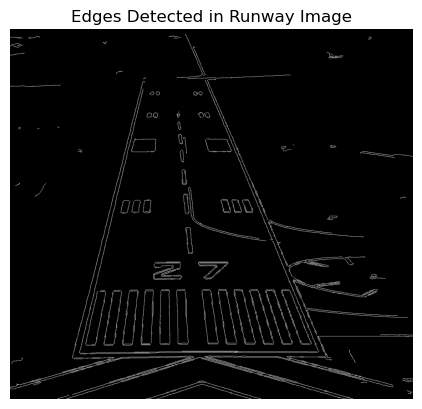

In [ ]:
edges_runway = edge_detection(image_runway, 50, 180)
plt.imshow(edges_runway, cmap='gray')
plt.title("Edges Detected in Runway Image")
plt.axis('off')
plt.show()

### Hough transform for line detection (runway)

In [48]:
def custom_hough_lines(edges, rho_res=1, theta_res=np.pi / 180, threshold=150):
    # Get the shape of the edge image
    height, width = edges.shape
    
    # Define the range of rho and theta in polar coordinates
    max_rho = int(np.sqrt(height ** 2 + width ** 2))
    rhos = np.arange(-max_rho, max_rho + 1, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    
    # Initialize the accumulator array
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=int)
    
    # Find the coordinates of non-zero pixels in the edge image (edge points)
    edge_points = np.argwhere(edges)
    
    # Accumulation process: voting for each edge point
    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            # Calculate the value of rho
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rhos == rho)[0][0]  # Find the index corresponding to rho
            accumulator[rho_idx, theta_idx] += 1   # Cast a vote
            
    # Find (rho, theta) pairs that meet the threshold
    lines = []
    for rho_idx, theta_idx in np.argwhere(accumulator >= threshold):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))
    
    return lines

### overlap in the image

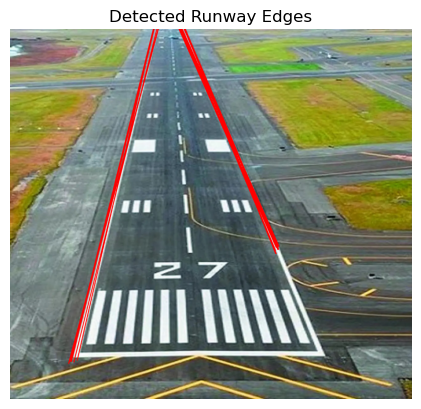

In [51]:
# Using Hough Transform from OpenCV
lines = custom_hough_lines(edges_runway, threshold=180)

# Draw the detected lines
output_image = cv2.imread('runway.jpeg')
for rho, theta in lines:
    # filter the lines based on the angle
    if theta < np.pi / 6  or theta > np.pi * 5 / 6:
        x1 = int(rho * np.cos(theta) - 1000 * np.sin(theta))
        y1 = int(rho * np.sin(theta) + 1000 * np.cos(theta))
        x2 = int(rho * np.cos(theta) + 1000 * np.sin(theta))
        y2 = int(rho * np.sin(theta) - 1000 * np.cos(theta))
    # draw the lines on the image
    cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.title("Detected Runway Edges")
plt.axis('off')
plt.show()

### Edge Detection in Space X Image 

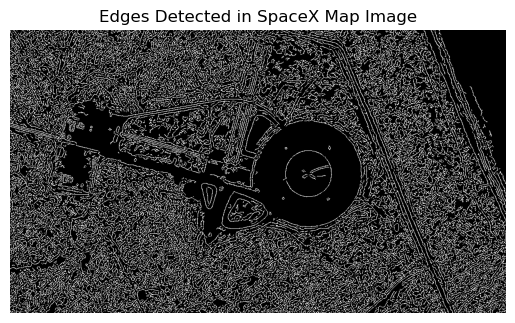

In [12]:
edges_spaceXmap = edge_detection(image_SpaceXmap, 10, 30)
plt.imshow(edges_spaceXmap, cmap='gray')
plt.title("Edges Detected in SpaceX Map Image")
plt.axis('off')
plt.show()

### Hough transform for circle detection (Space X)

In [ ]:
def find_hough_circles(image, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold, post_process = True):
  #image size
  img_height, img_width = edge_image.shape[:2]
  
  # R and Theta ranges
  dtheta = int(360 / num_thetas)
  
  ## Thetas is bins created from 0 to 360 degree with increment of the dtheta
  thetas = np.arange(0, 360, step=dtheta)
  
  ## Radius ranges from r_min to r_max 
  rs = np.arange(r_min, r_max, step=delta_r)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Evaluate and keep ready the candidate circles dx and dy for different delta radius
  # based on the the parametric equation of circle.
  # x = x_center + r * cos(t) and y = y_center + r * sin(t),  
  # where (x_center,y_center) is Center of candidate circle with radius r. t in range of [0,2PI)
  circle_candidates = []
  for r in rs:
    for t in range(num_thetas):
      #instead of using pre-calculated cos and sin theta values you can calculate here itself by following
      #circle_candidates.append((r, int(r*cos(2*pi*t/num_thetas)), int(r*sin(2*pi*t/num_thetas))))
      #but its better to pre-calculate and use it here.
      circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
  
  # Hough Accumulator, we are using defaultdic instead of standard dict as this will initialize for key which is not 
  # aready present in the dictionary instead of throwing exception.
  accumulator = defaultdict(int)
  
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
        for r, rcos_t, rsin_t in circle_candidates:
          x_center = x - rcos_t
          y_center = y - rsin_t
          accumulator[(x_center, y_center, r)] += 1 #vote for current candidate
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
  out_circles = []
  
  # Sort the accumulator based on the votes for the candidate circles 
  for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      # Shortlist the circle for final result
      out_circles.append((x, y, r, current_vote_percentage))
      print(x, y, r, current_vote_percentage)
      
  
  # Post process the results, can add more post processing later.
  if post_process :
    pixel_threshold = 5
    postprocess_circles = []
    for x, y, r, v in out_circles:
      # Exclude circles that are too close of each other
      # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
      # Remove nearby duplicate circles based on pixel_threshold
      if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
        postprocess_circles.append((x, y, r, v))
    out_circles = postprocess_circles
  
  # Draw shortlisted circles on the output image
  for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,0,255), 2)
    
  return output_img, out_circles

### Overlap in the image
- to run the code for result, you need to spend about 11 mins

633 306 50 0.59
633 305 50 0.55
632 306 49 0.53
835 131 32 0.48
220 379 70 0.48
366 503 82 0.48
291 418 31 0.47
317 428 31 0.47
201 504 68 0.47
298 489 43 0.47
592 525 35 0.47
495 64 43 0.46
355 152 102 0.46
819 109 30 0.46
917 311 35 0.46
630 521 78 0.46
72 520 42 0.46
777 514 30 0.46
1011 537 33 0.46
455 92 66 0.45
325 93 58 0.45
425 67 31 0.45
39 179 34 0.45
632 305 49 0.45
957 364 55 0.45
883 408 84 0.45
108 427 101 0.45
909 421 72 0.45
844 467 114 0.45
130 475 71 0.45
337 493 84 0.45
328 449 32 0.45
73 483 58 0.45
636 506 40 0.45
1000 522 30 0.45
256 523 31 0.45
1014 538 35 0.45
991 552 40 0.45
276 63 58 0.44
361 49 43 0.44
346 68 59 0.44
756 62 33 0.44
336 144 106 0.44
320 79 38 0.44
328 77 34 0.44
378 77 34 0.44
37 82 32 0.44
351 84 35 0.44
766 87 30 0.44
317 123 30 0.44
69 164 60 0.44
817 164 37 0.44
94 172 42 0.44
456 193 41 0.44
82 193 34 0.44
633 305 113 0.44
126 279 70 0.44
845 327 70 0.44
103 394 63 0.44
889 425 94 0.44
135 369 32 0.44
227 384 43 0.44
871 421 76 0.44
343 4

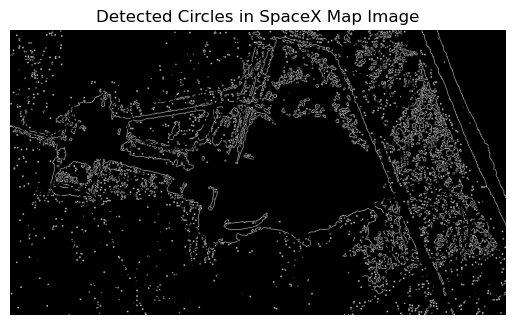

In [ ]:
outputimg, circles = find_hough_circles(image_SpaceXmap,edges_spaceXmap, 30, 115, 1, 100, 0.44, True)
# Assuming outputimg is the image with detected circles (in BGR format)
output_image = cv2.cvtColor(outputimg, cv2.COLOR_BGR2RGB)
plt.imshow(outputimg)
plt.title("Detected Circles in SpaceX Map Image")
plt.axis('off')
plt.show()